In [1]:
%cd ..
!git clone https://github.com/PieBob851/LfP-Rubix-Cube.git
%cd LfP-Rubix-Cube

/
Cloning into 'LfP-Rubix-Cube'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 18), reused 31 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 31.94 KiB | 545.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.
/LfP-Rubix-Cube


# Imports & Utils


In [2]:
from model.encoder import Encoder
from model.planner import Planner
from model.actor import Actor
import torch
from torch import nn, zeros
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import random
import copy
import numpy as np
import glob
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
!pip install magiccube
!pip install kociemba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kociemba: filename=kociemba-1.2.1-cp311-cp311-linux_x86_64.whl size=6800268 sha256=5f2fe159af5141f282d529ccf9f6e3224ba4db6aa2c7e6188122d91f7acc1a60
  Stored in directory: /root/.cache/pip/wheels/6c/51/2f/f3b8548d55efe500bd3b8880b0c59e7c59d0bf765c5676c036
Successfully built kociemba


In [4]:
import magiccube
import copy
from magiccube.cube_base import Color, Face
from magiccube.cube_move import CubeMove
from magiccube.cube_print import CubePrintStr
from magiccube.solver.basic.basic_solver import BasicSolver
import kociemba

cube = magiccube.Cube(3,"YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")

def get_face_state(cube, face):
    array_values = np.array([[color.value for color in row] for row in cube.get_face(face)])
    tensor = torch.tensor(array_values.flatten(), dtype=torch.int64)
    return torch.nn.functional.one_hot(tensor, num_classes=6).flatten()

#state space
def get_cube_state(cube):
    return torch.stack([get_face_state(cube, Face.L), get_face_state(cube, Face.R), get_face_state(cube, Face.D), get_face_state(cube, Face.U), get_face_state(cube, Face.B), get_face_state(cube, Face.F)], dim=0)

def batch_cube_state(cube_list):
    current_states = []

    for cube in cube_list:
      current_states.append(get_cube_state(cube))

    current_states = torch.stack(current_states)

    return current_states.view(current_states.size(0), -1)

def batch_apply_action(cube_list, action_list):
  for i in range(len(cube_list)):
    cube_list[i]._rotate_once(action_list[i])

  return cube_list

def get_kociemba_solve(cube):
  in_format = "YRGOBW"
  out_format = "ULFRBD"
  ordered_format = "URFDLB"

  translation_table_1 = str.maketrans(in_format, out_format)
  translation_table_2 = str.maketrans(out_format, ordered_format)
  printer = CubePrintStr(cube)
  string = printer.print_cube().replace(" ","").replace("\n", "").translate(translation_table_1)
  formatted = string[0:9] + string[15:18] + string[27:30] + string[39:42] \
              + string[12:15] + string[24:27] + string[36:39] + string[-9:] \
              + string[9:12] + string[21:24] + string[33:36] \
              + string[18:21] + string[30:33] + string[42:45]

  return kociemba.solve(formatted)



#action space
movements = ["L", "L'", "L2", "R", "R'", "R2", "D", "D'", "D2", "U", "U'", "U2", "B", "B'", "B2", "F", "F'", "F2"]
reversals = ["L'", "L", "L2", "R'", "R", "R2", "D'", "D", "D2", "U'", "U", "U2", "B'", "B", "B2", "F'", "F", "F2"]
reverse_index = {0: 1, 1: 0, 2: 2, 3: 4, 4: 3, 5: 5, 6: 7, 7: 6, 8: 8, 9: 10, 10: 9, 11: 11, 12: 13, 13: 12, 14: 14, 15: 16, 16:15, 17:17}
move_dict =  {"L": 0, "L'": 1, "L2": 2, "R": 3, "R'": 4, "R2": 5, "D": 6, "D'": 7, "D2": 8, "U": 9, "U'": 10, "U2": 11, "B": 12, "B'": 13, "B2": 14, "F": 15, "F'": 16, "F2": 17}
reversals = [CubeMove.create(move_str) for move_str in reversals]
movements = [CubeMove.create(move_str) for move_str in movements]

# cube._rotate_once(movements[8])
# solver = BasicSolver(cube)
# cube_copy = copy.deepcopy(cube)
# solver.solve()

# Data Collection

Different ways to collect data (only one should be used)

Random move selection - at every timestep, a random move is chosen

In [9]:
# random move at every step for dataset creation
import torch
import numpy as np
import random

action_dim = 18
state_dim = 54 * 6
num_samples = 1000000

data_raw = torch.zeros((num_samples, action_dim + state_dim))
cube = magiccube.Cube(3,"YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")
for i in range(num_samples):
  if i % 10000 == 0:
    print(f"Sample: {i}")
  state = get_cube_state(cube).flatten()
  data_raw[i, :state_dim] = state

  action = random.choice(range(action_dim))
  data_raw[i, state_dim + action] = 1

  cube._rotate_once(movements[action])

Sample: 0
Sample: 10000
Sample: 20000
Sample: 30000
Sample: 40000
Sample: 50000
Sample: 60000
Sample: 70000
Sample: 80000
Sample: 90000
Sample: 100000
Sample: 110000
Sample: 120000
Sample: 130000
Sample: 140000
Sample: 150000
Sample: 160000
Sample: 170000
Sample: 180000
Sample: 190000
Sample: 200000
Sample: 210000
Sample: 220000
Sample: 230000
Sample: 240000
Sample: 250000
Sample: 260000
Sample: 270000
Sample: 280000
Sample: 290000
Sample: 300000
Sample: 310000
Sample: 320000
Sample: 330000
Sample: 340000
Sample: 350000
Sample: 360000
Sample: 370000
Sample: 380000
Sample: 390000
Sample: 400000
Sample: 410000
Sample: 420000
Sample: 430000
Sample: 440000
Sample: 450000
Sample: 460000
Sample: 470000
Sample: 480000
Sample: 490000
Sample: 500000
Sample: 510000
Sample: 520000
Sample: 530000
Sample: 540000
Sample: 550000
Sample: 560000
Sample: 570000
Sample: 580000
Sample: 590000
Sample: 600000
Sample: 610000
Sample: 620000
Sample: 630000
Sample: 640000
Sample: 650000
Sample: 660000
Sample: 6

Random move selection with reversing - starts with a solved cube, then advances move_depth steps forward with random move selection. After this, it reverses those moves (so the cube is once again solved).

In [ ]:
# forward set number of moves, before reversing
action_dim = 18
state_dim = 54 * 6
num_samples = 100000
move_depth = 16  # Number of forward moves before reversing

data_raw = torch.zeros((num_samples, action_dim + state_dim))
cube = magiccube.Cube(3, "YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")

i = 0
while i < num_samples:
  forward_actions = []
  for _ in range(move_depth):
    if i % 10000 == 0:
        print(f"Sample: {i}")
    state = get_cube_state(cube).flatten()
    data_raw[i, :state_dim] = state

    action = random.choice(range(action_dim))
    data_raw[i, state_dim + action] = 1
    cube._rotate_once(movements[action])
    forward_actions.append(action)

    i += 1
    if i >= num_samples:
      break

  for action in reversed(forward_actions):
    if i % 10000 == 0:
        print(f"Sample: {i}")
    state = get_cube_state(cube).flatten()
    data_raw[i, :state_dim] = state

    reverse_action = reverse_index[action]
    data_raw[i, state_dim + reverse_action] = 1
    cube._rotate_once(movements[reverse_action])

    i += 1
    if i >= num_samples:
      break

Using MacgicCube's scramble() and solve() functions - generates a random state, then solves the cube forward from that state.

In [9]:
import kociemba
action_dim = 18
state_dim = 54 * 6
num_samples = 1000000
move_depth = 16

data_raw = torch.zeros((num_samples, action_dim + state_dim))
solved_cube = magiccube.Cube(3, "YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")

i = 0
while i < num_samples:
  cube = copy.deepcopy(solved_cube)
  action_cube = copy.deepcopy(cube)
  scramble_history = action_cube.scramble(move_depth)
  solve_history = get_kociemba_solve(action_cube).split()
  if len(solve_history) > 16:
    pass
  else:
    total_dim = len(scramble_history) + len(solve_history)
    padding_needed = 32 - total_dim
    for j in range(move_depth):
      if i % 10000 == 0:
          print(f"Sample: {i}")
      state = get_cube_state(cube).flatten()
      data_raw[i, :state_dim] = state

      action = move_dict[str(scramble_history[j])]
      data_raw[i, state_dim + action] = 1
      cube._rotate_once(movements[action])
      i += 1

      if i >= num_samples:
        break
    for action in solve_history:
      if i % 10000 == 0:
          print(f"Sample: {i}")
      state = get_cube_state(cube).flatten()
      data_raw[i, :state_dim] = state

      raw_action = move_dict[str(action)]
      data_raw[i, state_dim + raw_action] = 1
      move = CubeMove.create(action)
      cube._rotate_once(move)

      i += 1
      if i >= num_samples:
        break

    i += padding_needed

Sample: 0
Sample: 10000
Sample: 20000
Sample: 30000
Sample: 40000
Sample: 50000
Sample: 60000
Sample: 70000
Sample: 80000
Sample: 90000
Sample: 100000
Sample: 110000
Sample: 120000
Sample: 130000
Sample: 140000
Sample: 150000
Sample: 160000
Sample: 170000
Sample: 180000
Sample: 190000
Sample: 200000
Sample: 210000
Sample: 220000
Sample: 230000
Sample: 240000
Sample: 250000
Sample: 260000
Sample: 270000
Sample: 280000
Sample: 290000
Sample: 300000
Sample: 310000
Sample: 320000
Sample: 330000
Sample: 340000
Sample: 350000
Sample: 360000
Sample: 370000
Sample: 380000
Sample: 390000
Sample: 400000
Sample: 410000
Sample: 420000
Sample: 430000
Sample: 440000
Sample: 450000
Sample: 460000
Sample: 470000
Sample: 480000
Sample: 490000
Sample: 500000
Sample: 510000
Sample: 520000
Sample: 530000
Sample: 540000
Sample: 550000
Sample: 560000
Sample: 570000
Sample: 580000
Sample: 590000
Sample: 600000
Sample: 610000
Sample: 620000
Sample: 630000
Sample: 640000
Sample: 650000
Sample: 660000
Sample: 6

In [10]:
#Getting Data

class Dataset:
    def __init__(self, data):
        self.data_list = data

    def sample_batch(self, batch_size):
        start_indices = np.random.randint(0, len(self.data_list) - 32, size=batch_size)[:, np.newaxis]
        indices = start_indices + np.arange(32)[np.newaxis, :]

        sample = self.data_list[indices]
        return sample

data = Dataset(data_raw)

In [11]:
latent_dim = 128

encoder = Encoder(state_dim + action_dim, layer_size=256, latent_dim=latent_dim).to(device)
planner = Planner(state_dim, state_dim, layer_size=1024, latent_dim=latent_dim).to(device)
actor = Actor(state_dim, action_dim, state_dim, layer_size=1024, latent_dim=latent_dim).to(device)

encoder_optimizer = Adam(encoder.parameters(), lr=5e-5)
planner_optimizer = Adam(planner.parameters(), lr=5e-5)
actor_optimizer = Adam(actor.parameters(), lr=1e-4)

# Training and Testing


In [12]:
import torch.distributions as dist
import torch.optim as optim
import torch.nn.functional as F

def train_sample(batch_size, beta, encoder, actor, planner, encoder_optimizer, actor_optimizer, planner_optimizer, data):
    sample = data.sample_batch(batch_size).to(device)
    current_state = sample[:, 0, :-18]
    current_action = sample[:, 0, -18:]
    goal_state = sample[:, -1, :-18]
    goal_action = sample[:, -1, -18:]

    z, mu_phi, sigma_phi = encoder.forward(sample)
    mu_psi, sigma_psi = planner.forward(current_state, goal_state)

    phi_gaussian = dist.Normal(mu_phi, sigma_phi)

    psi_gaussian = dist.Normal(mu_psi, sigma_psi)

    KL_loss = torch.sum(dist.kl.kl_divergence(phi_gaussian, psi_gaussian))

    policy_action, _ = actor.forward(current_state.unsqueeze(1), z.unsqueeze(1), goal_state.unsqueeze(1))

    action_loss = F.cross_entropy(policy_action.squeeze(1), current_action)

    loss = beta * KL_loss + action_loss

    encoder_optimizer.zero_grad()
    planner_optimizer.zero_grad()
    actor_optimizer.zero_grad()

    loss.backward()

    encoder_optimizer.step()
    planner_optimizer.step()
    actor_optimizer.step()
    return loss

In [13]:
loss_list = []
batch_list = []
for batch in range(10000):
    loss = train_sample(32, .9, encoder, actor, planner, encoder_optimizer, actor_optimizer, planner_optimizer, data)
    if batch % 100 == 0:
        print(f"Batch: {batch}, Loss: {loss}")
        loss_list.append(loss)
        batch_list.append(batch)

Batch: 0, Loss: 11.584511756896973
Batch: 100, Loss: 2.095783233642578
Batch: 200, Loss: 2.406536817550659
Batch: 300, Loss: 2.5295205116271973
Batch: 400, Loss: 2.2542388439178467
Batch: 500, Loss: 2.3457558155059814
Batch: 600, Loss: 1.9488890171051025
Batch: 700, Loss: 2.1860296726226807
Batch: 800, Loss: 2.2028629779815674
Batch: 900, Loss: 1.9316964149475098
Batch: 1000, Loss: 1.913192629814148
Batch: 1100, Loss: 2.276026487350464
Batch: 1200, Loss: 2.067229747772217
Batch: 1300, Loss: 2.2296886444091797
Batch: 1400, Loss: 2.046100616455078
Batch: 1500, Loss: 2.1821415424346924
Batch: 1600, Loss: 2.1878011226654053
Batch: 1700, Loss: 2.0643150806427
Batch: 1800, Loss: 1.9835386276245117
Batch: 1900, Loss: 2.036116600036621
Batch: 2000, Loss: 2.1073577404022217
Batch: 2100, Loss: 2.260941505432129
Batch: 2200, Loss: 2.15157413482666
Batch: 2300, Loss: 1.6577122211456299
Batch: 2400, Loss: 2.0471863746643066
Batch: 2500, Loss: 1.8562239408493042
Batch: 2600, Loss: 2.1263022422790527

Text(0.5, 1.0, "Kociemba's Solver Loss")

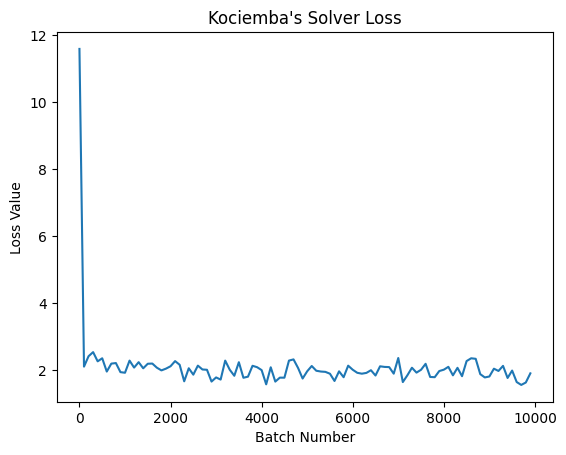

In [24]:
loss_vals = [loss.item() for loss in loss_list]
plt.plot(batch_list, loss_vals)
plt.xlabel("Batch Number")
plt.ylabel("Loss Value")
plt.title("Kociemba's Solver Loss")


In [14]:
def scramble_n(cube, n):
    for _ in range(n):
        action = random.choice(movements)
        cube._rotate_once(action)

def attempt_solve(scramble_moves, max_moves):
    cube = magiccube.Cube(3,"YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")
    goal_state = get_cube_state(cube).flatten().unsqueeze(0).to(device)
    scramble_n(cube, scramble_moves)
    with torch.no_grad():
      current_state = get_cube_state(cube).flatten().unsqueeze(0).to(device)

      for t in range(max_moves):
        if t % 32 == 0:
            mu_psi, sigma_psi = planner.forward(current_state.float(), goal_state.float())
        z = mu_psi + sigma_psi * torch.randn_like(sigma_psi)

        actor_dist, _ = actor.forward(current_state.unsqueeze(1), z.unsqueeze(1), goal_state.unsqueeze(1))
        action_index = torch.argmax(actor_dist, -1)

        cube._rotate_once(movements[action_index])
        current_state = get_cube_state(cube).flatten().unsqueeze(0).to(device)
        if cube.is_done():
            return t + 1
    return -1


def test_batch(batch_size):

    cubes = []
    histories = []

    for i in range(batch_size):
      cube = magiccube.Cube(3,"YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")
      history = cube.scramble(1)

      cubes.append(cube)
      histories.append(history)

    return cubes, histories

def test_sample(batch_size, encoder, actor, planner):

    goal_cube = magiccube.Cube(3,"YYYYYYYYYRRRRRRRRRGGGGGGGGGOOOOOOOOOBBBBBBBBBWWWWWWWWW")
    goal_state = get_cube_state(goal_cube)
    goal_state = goal_state.unsqueeze(0).repeat(batch_size, 1, 1).to(device)
    goal_state = goal_state.view(goal_state.size(0), -1)

    cubes, histories = test_batch(batch_size)

    solved = [False] * batch_size
    steps_taken = [0] * batch_size

    with torch.no_grad():
      current_state = batch_cube_state(cubes).to(device)

      mu_psi, sigma_psi = planner.forward(current_state.float(), goal_state.float())
      z = torch.normal(mu_psi, sigma_psi)
      actor_dist, _ = actor.forward(current_state.unsqueeze(1), z.unsqueeze(1), goal_state.unsqueeze(1))

      best_actions = torch.argmax(actor_dist, -1)

      #evaluate
      for i, action_index in enumerate(best_actions):
        if not solved[i]:
          cubes[i]._rotate_once(movements[action_index])
          steps_taken[i] += 1
          if cubes[i].is_done():
            solved[i] = True


    num_successful = sum(solved)
    print("Number of successful solves: ", num_successful)



In [25]:
solve_counts = []
for d in range(1, 11):
  solve_count = 0
  for i in range(1000):
    moves = attempt_solve(d, 30)
    if moves > 0:
      solve_count += 1
  print(d, ": ", solve_count)
  solve_counts.append(solve_count)

solve_count = 0
for i in range(1000):
  moves = attempt_solve(30, 80)
  if moves > 0:
    solve_count += 1
print(solve_count)

1 :  1000
2 :  953
3 :  757
4 :  530
5 :  370
6 :  232
7 :  134
8 :  79
9 :  43
10 :  30
0


Text(0.5, 0, 'Number of Successful Solves')

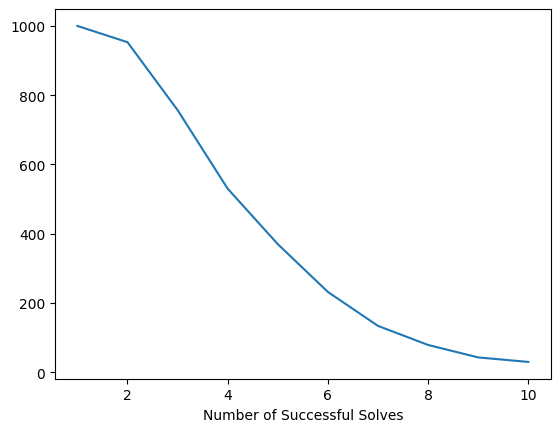

In [26]:
depths = range(1,11)

plt.plot(depths, solve_counts)
plt.xlabel("Scramble Depth")
plt.xlabel("Number of Successful Solves")